<a href="https://colab.research.google.com/github/ishikaarora/pytorch-tutorials/blob/master/cifar_defense_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## General setup and import functions

In [0]:
from __future__ import print_function, division
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import random

plt.ion()   # interactive mode

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
cifar10_mean = [0.49139968 , 0.48215841 , 0.44653091]
cifar10_std = [0.24703223,  0.24348513 , 0.26158784]

In [0]:
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean,cifar10_std)
])

testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

0it [00:00, ?it/s]

170500096it [00:06, 27497810.56it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


#### Helper functions

In [0]:
class mymodel(nn.Module):
    """Custom Model"""

    def __init__(self, in_features, hidden_dim, n_classes):
        """Custom Model Builder."""
        super(mymodel, self).__init__()
        
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, n_classes)
   
  
    def forward(self, images):
        """Perform forward."""
        
        images_vec = images.view(images.size(0), -1)
        hidden_out = F.relu(self.fc1(images_vec))
        hidden_out = F.relu(self.fc2(hidden_out))
        scores = self.fc3(hidden_out)

        return scores

In [0]:
def calculate_accuracy(model, loader, print_freq=1000, attack=False):
    model.eval()
    total = 0
    correct = 0
    # with torch.no_grad():
    for data in loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

    if total % print_freq == 0:
        print("Current Accuracy: {} / {} = {}".format(correct, total, correct/total*100))
    return (correct/total)*100, total

##### Other metric functions

In [0]:
import pandas as pd
import numpy as np
from scipy import interp

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum()
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int),
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(),
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(),
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"],
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

### Defense experiments

Generate and save adversarial images


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/' 

In [0]:
cw_images = torch.load(root_path+"cw2_images.pt", map_location=torch.device(device))

In [0]:
print(len(cw_images))
print(cw_images[0].shape)

300
torch.Size([4, 3, 224, 224])


In [0]:
cw_images2 = torch.cat(cw_images, dim=0)
print(cw_images2.shape)

torch.Size([1200, 3, 224, 224])


In [0]:
torch.save(cw_images2, root_path+'cw_images.pt')

In [0]:
cw_images = torch.load(root_path+"cw_images.pt", map_location=torch.device(device))

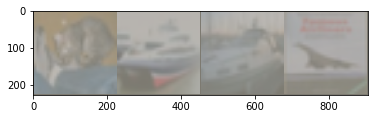

In [0]:
attack_acc, data_size = attack_accuracy(model, testloader, attack_type='cw_attack')
print(attack_acc, data_size)

In [0]:
pymodel = foolbox.models.PyTorchModel(model, bounds=(0, 255), num_classes=10)
images, labels = foolbox.utils.samples(dataset='cifar10', batchsize=16, data_format='channels_first', bounds=(0, 1))
attack = foolbox.attacks.CarliniWagnerL2Attack(pymodel)
adversarials = attack(images, labels)

### Create Adversarial samples from one of the three attacks

In [0]:
def create_adversarial(model, images, labels, attack_type=None, **kwargs):
    if attack_type is not None:
        if attack_type == "fgsm_attack":
            perturbed_images = fgsm_attack(model, images, labels, **kwargs)
        elif attack_type == "cw_attack":
            perturbed_images = cw_attack(model, images, labels, **kwargs)
        else:
            perturbed_images = transfer_attack(proxy_model, images, labels, **kwargs)
    else:
      idx = random.uniform(0,1)
      
      ##############################################################
      #########  Different attack functions called here  ###########
      ##############################################################
      
      if idx < 0.5:
          perturbed_images = fgsm_attack(model, images, labels, **kwargs)
      # elif idx < 0.66:
      #     perturbed_images = cw_attack(model, images, labels, **kwargs)
      else:
          perturbed_images = transfer_attack(proxy_model, images, labels, **kwargs)

    return perturbed_images

### Load the target model and compare accuracies


In [0]:
model = torch.load("mymodel.pt", map_location=torch.device(device))

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

##### Target Model accuracy (no attack)

In [0]:
model_acc, data_size = calculate_accuracy(model, testloader)
print(model_acc, data_size)

Current Accuracy: 9036 / 10000 = 90.36
90.36 10000


#### Model accuracy (after attack)

Do we need the labels from the test dataset. Can we attack without that?        
Should we always attack and not only when the label is correct?

In [0]:
def attack_accuracy(model, loader, attack_type=None, print_freq=1000, epsilon=0.1):
    model.eval()
    total = 0
    correct = 0
    show_im = True
    all_labels = []
    all_preds = []
    all_probs = []

    for data in loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        kwargs = {'loss_fn': nn.CrossEntropyLoss(), 'epsilon': epsilon}
        images = create_adversarial(model, images, labels, attack_type=attack_type, **kwargs)

        # if show_im:
        #   out = torchvision.utils.make_grid(images.cpu().detach())
        #   imshow(out)
        #   show_im = False

        with torch.no_grad():
          outputs = model(images)
          out_prob = F.softmax(outputs, dim=1)

        _,predicted = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

        all_labels.append(labels.cpu().numpy())
        all_preds.append(predicted.cpu().numpy())
        all_probs.append(out_prob.cpu().numpy())

        if total % print_freq == 0:
            print("Current Accuracy: {} / {} = {}".format(correct, total, correct/total*100))
    
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)

    report_with_auc = class_report(
                            y_true = all_labels,
                            y_pred = all_preds,
                            y_score= all_probs)
           
    return (correct/total)*100, total, report_with_auc

In [0]:
# Calculate model accuracy after attack 
# 0.5 FGSM - 0.5 Transfer
attack_acc, data_size, report_with_auc = attack_accuracy(model, testloader)
print(attack_acc, data_size)
print(report_with_auc) 

Current Accuracy: 237 / 1000 = 23.7
Current Accuracy: 482 / 2000 = 24.099999999999998
Current Accuracy: 738 / 3000 = 24.6
Current Accuracy: 990 / 4000 = 24.75
Current Accuracy: 1244 / 5000 = 24.88
Current Accuracy: 1489 / 6000 = 24.816666666666666
Current Accuracy: 1746 / 7000 = 24.942857142857143
Current Accuracy: 1999 / 8000 = 24.9875
Current Accuracy: 2256 / 9000 = 25.066666666666666
Current Accuracy: 2500 / 10000 = 25.0
25.0 10000
             precision  recall  f1-score  support     pred       AUC
0             0.705521   0.345  0.463398   1000.0    489.0  0.903373
1             0.821596   0.175  0.288541   1000.0    213.0  0.886548
2             0.306108   0.446  0.363044   1000.0   1457.0  0.793834
3             0.137305   0.922  0.239015   1000.0   6715.0  0.802883
4             0.431118   0.266  0.329004   1000.0    617.0  0.793821
5             0.555556   0.175  0.266160   1000.0    315.0  0.787021
6             1.000000   0.011  0.021761   1000.0     11.0  0.742593
7        

In [0]:
# Calculate model accuracy after attack 
# 50-50 FGSM-Transfer, eps=0.15
attack_acc, data_size, report_with_auc = attack_accuracy(model, testloader, print_freq=1000, epsilon=0.15)
print(attack_acc, data_size)
print(report_with_auc) 

Current Accuracy: 166 / 1000 = 16.6
Current Accuracy: 336 / 2000 = 16.8
Current Accuracy: 514 / 3000 = 17.133333333333333
Current Accuracy: 693 / 4000 = 17.325
Current Accuracy: 854 / 5000 = 17.080000000000002
Current Accuracy: 1012 / 6000 = 16.866666666666667
Current Accuracy: 1181 / 7000 = 16.87142857142857
Current Accuracy: 1372 / 8000 = 17.150000000000002
Current Accuracy: 1556 / 9000 = 17.28888888888889
Current Accuracy: 1725 / 10000 = 17.25
17.25 10000
             precision  recall  f1-score  support    pred       AUC
0             0.752577  0.1460  0.244556   1000.0   194.0  0.868766
1             0.850000  0.0170  0.033333   1000.0    20.0  0.791239
2             0.194269  0.5830  0.291427   1000.0  3001.0  0.746987
3             0.132351  0.8620  0.229469   1000.0  6513.0  0.723141
4             0.384615  0.0900  0.145867   1000.0   234.0  0.744627
5             0.615385  0.0160  0.031189   1000.0    26.0  0.724983
8             0.916667  0.0110  0.021739   1000.0    12.0  0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


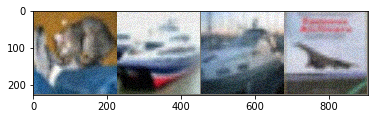

Current Accuracy: 162 / 1000 = 16.2
Current Accuracy: 335 / 2000 = 16.75
Current Accuracy: 515 / 3000 = 17.166666666666668
Current Accuracy: 690 / 4000 = 17.25
Current Accuracy: 857 / 5000 = 17.14
Current Accuracy: 1021 / 6000 = 17.016666666666666
Current Accuracy: 1185 / 7000 = 16.92857142857143
Current Accuracy: 1376 / 8000 = 17.2
Current Accuracy: 1554 / 9000 = 17.266666666666666
Current Accuracy: 1720 / 10000 = 17.2
17.2 10000


In [0]:
# Calculate model accuracy after attack 
# 100 FGSM (no clamping)
attack_acc, data_size = attack_accuracy(model, testloader, attack_type="fgsm_attack", print_freq=1000, epsilon=0.15)
print(attack_acc, data_size)

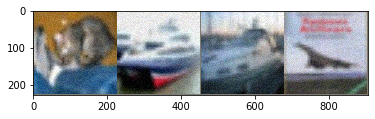

Current Accuracy: 170 / 1000 = 17.0
Current Accuracy: 343 / 2000 = 17.150000000000002
Current Accuracy: 525 / 3000 = 17.5
Current Accuracy: 709 / 4000 = 17.724999999999998
Current Accuracy: 872 / 5000 = 17.44
Current Accuracy: 1032 / 6000 = 17.2
Current Accuracy: 1205 / 7000 = 17.214285714285715
Current Accuracy: 1396 / 8000 = 17.45
Current Accuracy: 1582 / 9000 = 17.57777777777778
Current Accuracy: 1750 / 10000 = 17.5
17.5 10000


In [0]:
# Calculate model accuracy after attack 
# 100 transfer (no clamping)
attack_acc, data_size = attack_accuracy(model, testloader, attack_type="transfer_attack", print_freq=1000, epsilon=0.15)
print(attack_acc, data_size)

In [0]:
# Calculate model accuracy after attack 
# 100 CW
attack_acc, data_size = attack_accuracy(model, testloader, attack_type="cw_attack", print_freq=1000, epsilon=0.15)
print(attack_acc, data_size)

KeyboardInterrupt: ignored

In [0]:
# Calculate model accuracy after attack 
# 33-33-33 FGSM-Transfer-CW
attack_acc, data_size = attack_accuracy(model, testloader, print_freq=1000, epsilon=0.15)
print(attack_acc, data_size)

AssertionError: ignored

### Retraining using Defensive Distillation

In [0]:
distil_model1 = torch.load("my_distil_model1.pt", map_location=torch.device(device))

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in distil_model1.parameters():
    param.requires_grad = False

In [0]:
distil_model2 = torch.load("my_distil_model2.pt", map_location=torch.device(device))

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in distil_model2.parameters():
    param.requires_grad = False

In [0]:
distil_model_acc, data_size = calculate_accuracy(distil_model, testloader)
print(distil_model_acc, data_size)

Current Accuracy: 9013 / 10000 = 90.13
90.13 10000


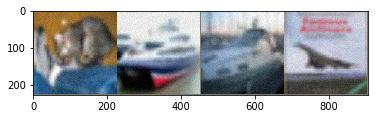

Current Accuracy: 206 / 1000 = 20.599999999999998
Current Accuracy: 422 / 2000 = 21.099999999999998
Current Accuracy: 642 / 3000 = 21.4
Current Accuracy: 857 / 4000 = 21.425
Current Accuracy: 1091 / 5000 = 21.82
Current Accuracy: 1305 / 6000 = 21.75
Current Accuracy: 1527 / 7000 = 21.814285714285713
Current Accuracy: 1766 / 8000 = 22.075
Current Accuracy: 1998 / 9000 = 22.2
Current Accuracy: 2221 / 10000 = 22.21
22.21 10000


In [0]:
# Calculate distilled model accuracy after attack 
# 100 FGSM (no clamping)
attack_acc1, data_size = attack_accuracy(distil_model, testloader, attack_type="fgsm_attack", print_freq=1000, epsilon=0.10)
print(attack_acc1, data_size)

(228, 906, 3)


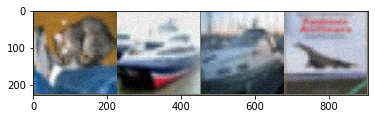

Current Accuracy: 215 / 1000 = 21.5
Current Accuracy: 444 / 2000 = 22.2
Current Accuracy: 670 / 3000 = 22.333333333333332
Current Accuracy: 903 / 4000 = 22.575
Current Accuracy: 1135 / 5000 = 22.7
Current Accuracy: 1355 / 6000 = 22.583333333333332
Current Accuracy: 1590 / 7000 = 22.714285714285715
Current Accuracy: 1835 / 8000 = 22.9375
Current Accuracy: 2079 / 9000 = 23.1
Current Accuracy: 2305 / 10000 = 23.05
23.05 10000


In [0]:
# Calculate distilled model accuracy after attack 
# 100% transfer (no clamping)
attack_acc1, data_size = attack_accuracy(distil_model, testloader, attack_type="transfer_attack", print_freq=1000, epsilon=0.10)
print(attack_acc1, data_size)

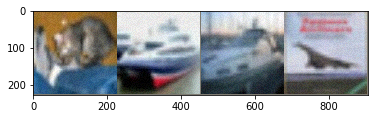

Current Accuracy: 392 / 1000 = 39.2
Current Accuracy: 790 / 2000 = 39.5
Current Accuracy: 1176 / 3000 = 39.2
Current Accuracy: 1581 / 4000 = 39.525
Current Accuracy: 1972 / 5000 = 39.44
Current Accuracy: 2321 / 6000 = 38.68333333333333
Current Accuracy: 2700 / 7000 = 38.57142857142858
Current Accuracy: 3094 / 8000 = 38.675
Current Accuracy: 3445 / 9000 = 38.27777777777778
Current Accuracy: 3852 / 10000 = 38.519999999999996
38.519999999999996 10000


In [0]:
# Calculate distilled model accuracy after attack 
# 100 FGSM (no clamping, new model with T=100)
attack_acc1, data_size = attack_accuracy(distil_model, testloader, attack_type="fgsm_attack", print_freq=1000, epsilon=0.10)
print(attack_acc1, data_size)

In [0]:
# Calculate distilled model accuracy after attack 
# 50-50 FGSM-Transfer (no clamping, model1 with T=100)
attack_acc1, data_size, report_with_auc = attack_accuracy(distil_model1, testloader, print_freq=1000, epsilon=0.10)
print(attack_acc1, data_size)
print(report_with_auc)

Current Accuracy: 394 / 1000 = 39.4
Current Accuracy: 784 / 2000 = 39.2
Current Accuracy: 1178 / 3000 = 39.266666666666666
Current Accuracy: 1588 / 4000 = 39.7
Current Accuracy: 1986 / 5000 = 39.72
Current Accuracy: 2347 / 6000 = 39.11666666666667
Current Accuracy: 2727 / 7000 = 38.957142857142856
Current Accuracy: 3120 / 8000 = 39.0
Current Accuracy: 3483 / 9000 = 38.7
Current Accuracy: 3885 / 10000 = 38.85
38.85 10000
             precision  recall  f1-score  support     pred       AUC
0             0.935252  0.2600  0.406886   1000.0    278.0  0.869486
1             0.980198  0.1980  0.329451   1000.0    202.0  0.782163
2             0.170017  0.8880  0.285393   1000.0   5223.0  0.838246
3             0.407148  0.5240  0.458242   1000.0   1287.0  0.849923
4             0.647059  0.3630  0.465086   1000.0    561.0  0.875013
5             0.881356  0.1040  0.186047   1000.0    118.0  0.723418
6             0.499130  0.5740  0.533953   1000.0   1150.0  0.896095
7             0.738550  

In [0]:
# Calculate distilled model accuracy after attack 
# 100 FGSM (no clamping, model1 with T=100)
attack_acc1, data_size, report_with_auc = attack_accuracy(distil_model1, testloader, attack_type="fgsm_attack", 
                                                          print_freq=1000, epsilon=0.15)
print(attack_acc1, data_size)
print(report_with_auc)

Current Accuracy: 250 / 1000 = 25.0
Current Accuracy: 470 / 2000 = 23.5
Current Accuracy: 697 / 3000 = 23.233333333333334
Current Accuracy: 931 / 4000 = 23.275000000000002
Current Accuracy: 1139 / 5000 = 22.78
Current Accuracy: 1346 / 6000 = 22.433333333333334
Current Accuracy: 1575 / 7000 = 22.5
Current Accuracy: 1798 / 8000 = 22.475
Current Accuracy: 2009 / 9000 = 22.322222222222223
Current Accuracy: 2237 / 10000 = 22.37
22.37 10000
             precision  recall  f1-score  support     pred       AUC
0             0.876923  0.0570  0.107042   1000.0     65.0  0.808555
1             1.000000  0.0450  0.086124   1000.0     45.0  0.694032
2             0.120045  0.8450  0.210225   1000.0   7039.0  0.715652
3             0.352642  0.3470  0.349798   1000.0    984.0  0.788162
4             0.565728  0.2410  0.338008   1000.0    426.0  0.841273
5             0.875000  0.0070  0.013889   1000.0      8.0  0.582141
6             0.412221  0.4250  0.418513   1000.0   1031.0  0.836861
7        

In [0]:
# Calculate distilled model accuracy after attack 
# 50-50 FGSM-Transfer (no clamping, model1 with T=100)
attack_acc1, data_size, report_with_auc = attack_accuracy(distil_model1, testloader, print_freq=1000, epsilon=0.15)
print(attack_acc1, data_size)
print(report_with_auc)

Current Accuracy: 248 / 1000 = 24.8
Current Accuracy: 472 / 2000 = 23.599999999999998
Current Accuracy: 706 / 3000 = 23.533333333333335
Current Accuracy: 937 / 4000 = 23.425
Current Accuracy: 1153 / 5000 = 23.06
Current Accuracy: 1356 / 6000 = 22.6
Current Accuracy: 1575 / 7000 = 22.5
Current Accuracy: 1800 / 8000 = 22.5
Current Accuracy: 2004 / 9000 = 22.26666666666667
Current Accuracy: 2238 / 10000 = 22.38
22.38 10000
             precision  recall  f1-score  support     pred       AUC
0             0.909091  0.0600  0.112570   1000.0     66.0  0.802393
1             1.000000  0.0350  0.067633   1000.0     35.0  0.695134
2             0.121183  0.8770  0.212942   1000.0   7237.0  0.724152
3             0.384698  0.3570  0.370332   1000.0    928.0  0.790772
4             0.595000  0.2380  0.340000   1000.0    400.0  0.841251
5             0.909091  0.0100  0.019782   1000.0     11.0  0.596368
6             0.426193  0.3840  0.403998   1000.0    901.0  0.834179
7             0.564356  

In [0]:
# Calculate distilled model accuracy after attack 
# 50-50 FGSM-Transfer (no clamping, new model with T=200)
attack_acc1, data_size, report_with_auc = attack_accuracy(distil_model2, testloader, print_freq=1000, epsilon=0.15)
print(attack_acc1, data_size)
print(report_with_auc)

Current Accuracy: 240 / 1000 = 24.0
Current Accuracy: 462 / 2000 = 23.1
Current Accuracy: 696 / 3000 = 23.200000000000003
Current Accuracy: 901 / 4000 = 22.525000000000002
Current Accuracy: 1139 / 5000 = 22.78
Current Accuracy: 1357 / 6000 = 22.616666666666667
Current Accuracy: 1575 / 7000 = 22.5
Current Accuracy: 1819 / 8000 = 22.7375
Current Accuracy: 2057 / 9000 = 22.855555555555558
Current Accuracy: 2273 / 10000 = 22.73
22.73 10000
             precision  recall  f1-score  support    pred       AUC
0             0.847826  0.1950  0.317073   1000.0   230.0  0.905831
1             1.000000  0.0030  0.005982   1000.0     3.0  0.559611
2             0.195763  0.4620  0.275000   1000.0  2360.0  0.672940
3             0.136879  0.7490  0.231459   1000.0  5472.0  0.734816
4             0.352941  0.0060  0.011799   1000.0    17.0  0.656722
5             0.483146  0.3010  0.370918   1000.0   623.0  0.814550
6             0.399170  0.4810  0.436281   1000.0  1205.0  0.817749
7             1.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## **Detector**

Entropy

In [0]:
import math
from PIL import Image
imageFile = 'test.jpg'
im = Image.open(imageFile)
rgbHistogram = im.histogram()
print 'Snannon Entropy for Red, Green, Blue:'
for rgb in range(3):
    totalPixels = sum(rgbHistogram[rgb * 256 : (rgb + 1) * 256])
    ent = 0.0
    for col in range(rgb * 256, (rgb + 1) * 256):
        freq = float(rgbHistogram[col]) / totalPixels
        if freq > 0:
            ent = ent + freq * math.log(freq, 2)
    ent = -ent
    print ent

Quantization


In [0]:
# Importing Image module from PIL package  
from PIL import Image  
import PIL  
  
# creating a image object (main image)  
im1 = Image.open("test.jpg")  
  
# quantize a image  
# im1 = im1.quantize(256)  
  
# to show specified image  
# im1.show()

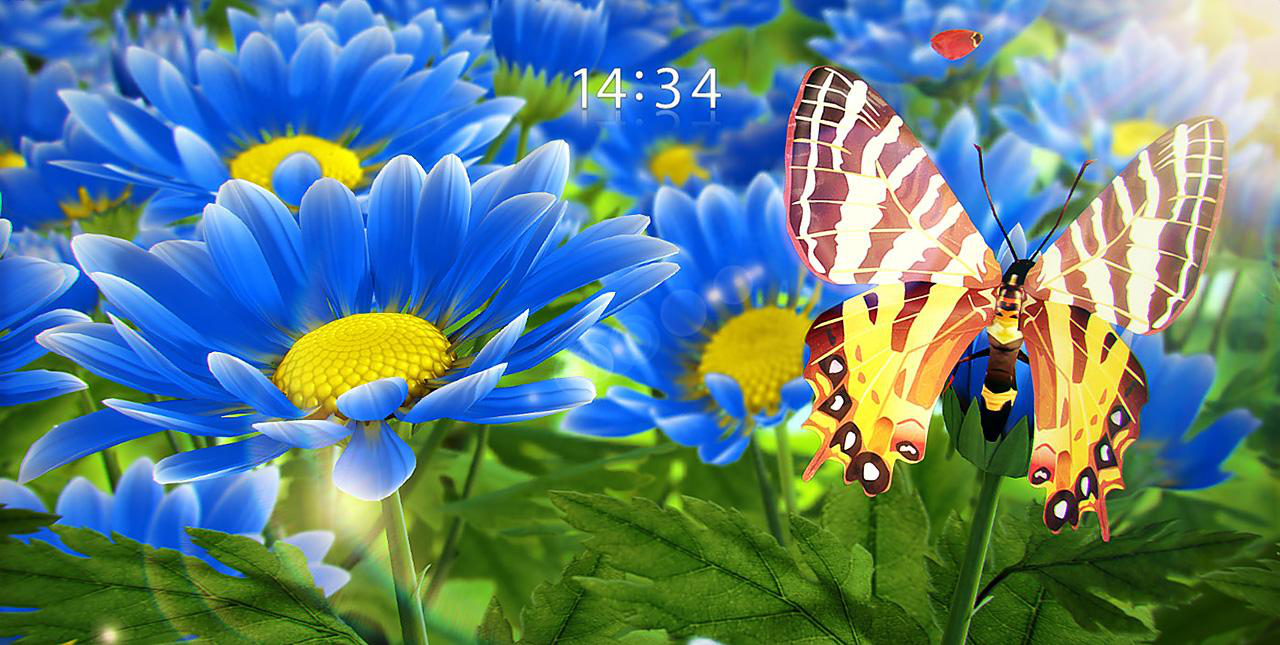

In [0]:
im1

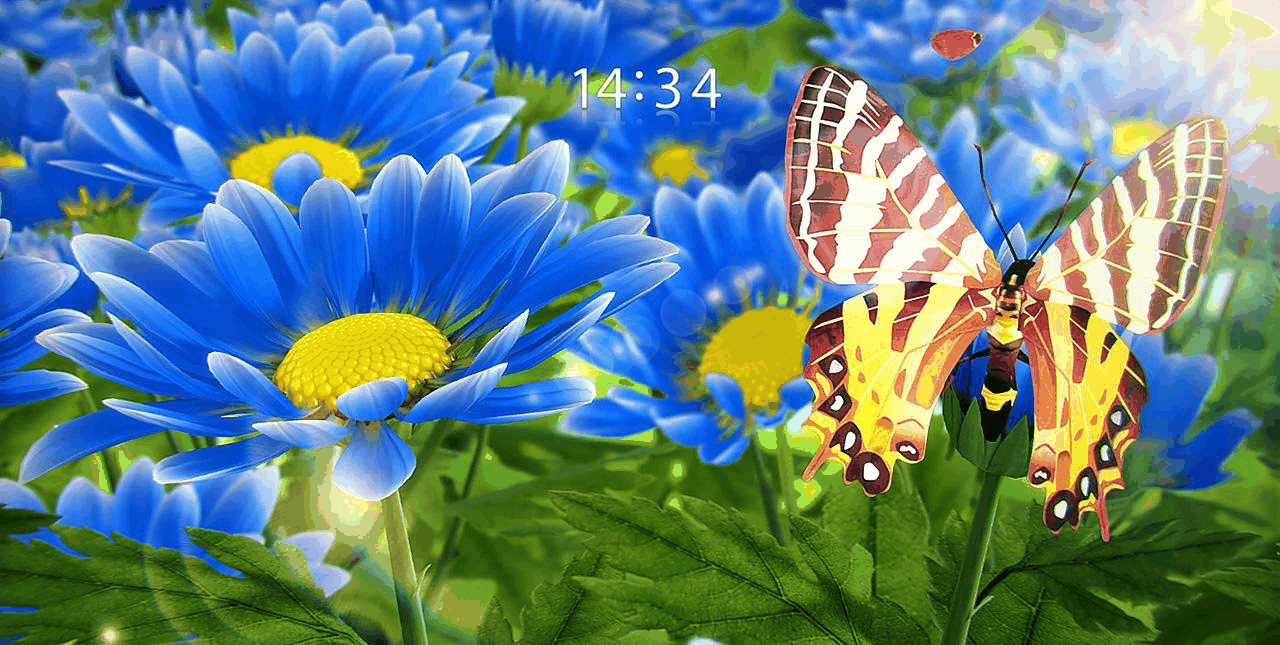

In [0]:
# quantize a image  
im1 = im1.quantize(256)  
  
# to show specified image  
im1

Spacial Smoothing

In [0]:
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=3):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter